In [23]:
import numpy as np
import pydot
from IPython.display import HTML, SVG, display
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    GenerateHtml,
    InverseDynamicsController,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    MultibodyPlant,
    Parser,
    Simulator,
    StartMeshcat,
    SceneGraph,
    PassThrough,
    Demultiplexer,
)

In [6]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [6]:
# -- Create Plant -- #
plant = MultibodyPlant(time_step=0.0)
scene_graph = SceneGraph()
plant.RegisterAsSourceForSceneGraph(scene_graph)
parser = Parser(plant=plant)
# parser.AddModelFromFile("./cartpole.urdf")
parser.AddModelFromFile("../models/singleAxisCatBot.urdf")
plant.Finalize()
context = plant.CreateDefaultContext()

Lets look at the context

In [7]:
print(context)

::_ Context
------------
Time: 0
States:
  10 continuous states
    0 0 0 0 0 0 0 0 0 0

Parameters:
  21 numeric parameter groups with
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
           1     0     0     0 1e-05 1e-05 1e-05     0     0     0
     10 parameters
           1     0     0     0 1e-05 1e-05 1e-05     0     0     0
     10 parameters
       0.0001   0.05      0      0    0.1 0.1025 0.1025      0      0      0
     10 parameters
       0.0001  -0.05      0      0    0.1 0.1025 0.1025      0      0      0
     10 parameters
             1    0.05       0       0 0.00045 0.00356 0.00356       0       0       0
     10 parameters
             1   -0.05       0       0 0.00045 0.00356 0.00356       0       0       0
     1

In [8]:
plant.get_actuation_input_port().FixValue(context, np.zeros(4))

In [ ]:
simulator = Simulator(plant, context)
simulator.AdvanceTo(5.0)
print(context)

# Visualization

In [7]:
meshcat.Delete()
meshcat.DeleteAddedControls()
builder = DiagramBuilder()

# Adds both MultibodyPlant and the SceneGraph, and wires them together.
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
# Note that we parse into both the plant and the scene_graph here.
Parser(plant, scene_graph).AddModelFromFile("../models/singleAxisCatBot.urdf")
plant.Finalize()

# Adds the MeshcatVisualizer and wires it to the SceneGraph.
visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

diagram = builder.Build()

In [8]:
context = diagram.CreateDefaultContext()
diagram.ForcedPublish(context)

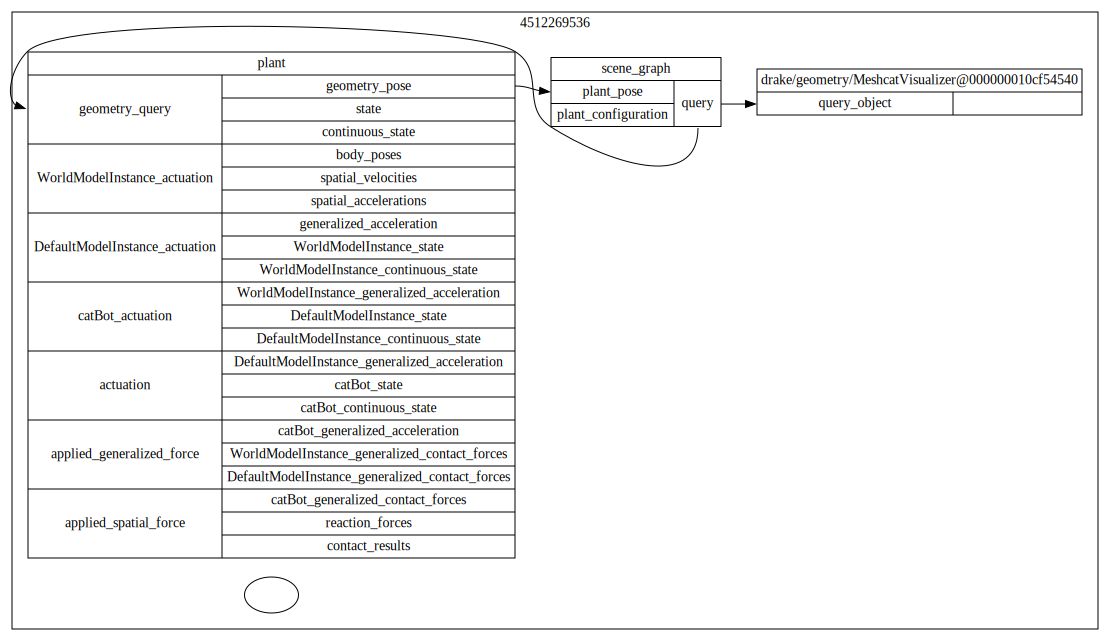

In [9]:
SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg())


In [10]:
plant_context = plant.GetMyMutableContextFromRoot(context)
plant.SetPositions(plant_context, [0, np.pi/4, np.pi/4, 0, 0])
plant.get_actuation_input_port().FixValue(plant_context, np.zeros(4))
print(context)


::_ Context (of a Diagram)
---------------------------
10 total discrete states in 1 groups
150 total numeric parameters in 21 groups
7 total abstract parameters

::_::plant Context
-------------------
Time: 0
States:
  1 discrete state groups with
     10 states
              0 0.785398 0.785398        0        0        0        0        0        0        0

Parameters:
  21 numeric parameter groups with
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
           1     0     0     0 1e-05 1e-05 1e-05     0     0     0
     10 parameters
           1     0     0     0 1e-05 1e-05 1e-05     0     0     0
     10 parameters
       0.0001   0.05      0      0    0.1 0.1025 0.1025      0      0      0
     10 parameters
       0.0001  -0.05  

In [15]:
simulator = Simulator(diagram, context)  # If you get an error, comment this line out
simulator.set_target_realtime_rate(1.0)
simulator.AdvanceTo(5.0)

# Adding a Controller

In [28]:
time_step = 1e-4
builder = DiagramBuilder()

# Adds both MultibodyPlant and the SceneGraph, and wires them together.
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=time_step)
# Note that we parse into both the plant and the scene_graph here.
model = Parser(plant, scene_graph).AddModelFromFile(
    "../models/singleAxisCatBot.urdf")
plant.Finalize()

# Adds the MeshcatVisualizer and wires it to the SceneGraph.
visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

# -- Add Controller -- #
# Based on https://github.com/elchun/ChessBot/blob/main/src/chess_bot/stations/teleop_station.py

num_model_positions = plant.num_positions(model)
model_position = builder.AddSystem(PassThrough(num_model_positions))
builder.ExportInput(model_position.get_input_port(), "model_position")
builder.ExportOutput(model_position.get_output_port(), "model_position_commanded")

# Export "state" outputs
demux = builder.AddSystem(
    Demultiplexer(2 * num_model_positions, num_model_positions))
builder.Connect(plant.get_state_output_port(model),
                demux.get_input_port())
builder.ExportOutput(demux.get_output_port(0),
                        "position_measured")
builder.ExportOutput(demux.get_output_port(1),
                        "velocity_estimated")
builder.ExportOutput(plant.get_state_output_port(model),
                        "state_estimated")

controller_plant = MultibodyPlant(time_step=time_step)
model = Parser(controller_plant).AddModelFromFile(
    "../models/singleAxisCatBot.urdf")
controller_plant.Finalize()

# Adds an approximation of the iiwa controller.
# TODO(russt): replace this with the joint impedance controller.
# kp = [100] * plant.num_positions()
# ki = [1] * plant.num_actuators()
# kd = [20] * plant.num_actuators()

kp = [100] * num_model_positions
ki = [1] * num_model_positions 
kd = [20] * num_model_positions
catbot_controller = builder.AddSystem(
    InverseDynamicsController(controller_plant, kp, ki, kd, False)
)
print('here')
catbot_controller.set_name("catbot_controller")
builder.Connect(
    plant.get_state_output_port(model),
    catbot_controller.get_input_port_estimated_state(),
)
builder.Connect(
    catbot_controller.get_output_port_control(), plant.get_actuation_input_port()
)
diagram = builder.Build()

SystemExit: Failure at systems/controllers/inverse_dynamics_controller.cc:41 in SetUp(): condition 'num_positions == num_actuators' failed.

/Users/elchun/opt/miniconda3/envs/68210/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
